In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import norm
from scipy.stats import zscore
import math
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
import statsmodels.api as sm
from sklearn.metrics import log_loss
from sklearn.metrics import mean_squared_error

# Data Pre-processing

In [2]:
# Load the data
psy_data = pd.read_csv('/content/drive/MyDrive/Psychometric data  - Simulated_Adaptive_Test_Data (2).csv')
print(psy_data.head())
print(psy_data.isna().sum())

   user_id  attempt_number section  item_id  score   item_type  \
0   218009               1   Intro      733    0.0  standalone   
1   218009               1   Intro     3352    0.0  standalone   
2   218009               1   Intro     3866    NaN      parent   
3   218009               1   Intro     3709    1.0       child   
4   218009               1   Intro     3861    NaN      parent   

   raw_difficulty  raw_ability_est  standard_error      skill  \
0          2.8400              NaN             NaN  Listening   
1          2.3200              NaN             NaN    Grammar   
2          2.2571              NaN             NaN    Reading   
3          2.2571              NaN             NaN    Reading   
4          1.5143              NaN             NaN  Listening   

   skill_ability_est  skill_standard_error       answered_at  
0                NaN                   NaN  24/09/2020 11:24  
1                NaN                   NaN  24/09/2020 11:25  
2                NaN   

In [3]:
psy_data_cleaned = psy_data.dropna()
print(psy_data_cleaned.head())
print(psy_data_cleaned.isna().sum())

    user_id  attempt_number    section  item_id  score   item_type  \
20   218009               1  Listening      126    1.0  standalone   
24   218009               1  Listening     1208    1.0  standalone   
25   218009               1  Listening      489    1.0  standalone   
26   218009               1  Listening      653    0.0  standalone   
27   218009               1  Listening      706    0.0  standalone   

    raw_difficulty  raw_ability_est  standard_error      skill  \
20         -0.0571         0.132166        0.620168  Listening   
24          0.3714         0.606756        0.552780  Listening   
25          0.5857         0.748132        0.536562  Listening   
26          0.7571         0.615311        0.515097  Listening   
27          0.6286         0.492151        0.497287  Listening   

    skill_ability_est  skill_standard_error       answered_at  
20          -0.636294              0.875707  24/09/2020 11:35  
24          -0.136294              0.687165  24/09/202

In [4]:
# Count the number of responses for each item
response_count = psy_data.groupby('item_id')['score'].count()

# Set threshold for the min. number of responses
min_responses = 50

# Get items with at least the minimum number of responses
valid_item_ids = response_count[response_count >= min_responses].index

# Filter the data to keep only those items
df_valid_items = psy_data[psy_data['item_id'].isin(valid_item_ids)]

# Add  raw_ability_est as a new column to df_valid_items
df_valid_items['raw_ability_est'] = df_valid_items.groupby('user_id')['score'].transform('mean')

# Step 2: Pivot to create the final item-response matrix
final_matrix = df_valid_items.pivot(index='user_id', columns='item_id', values='score')

# Step 3: Incorporate 'raw_ability_est'and 'raw_difficulty' as a new column, aligned by 'user_id'
final_matrix['raw_ability_est'] = df_valid_items.drop_duplicates(subset='user_id')[['user_id', 'raw_ability_est']].set_index('user_id')['raw_ability_est']
final_matrix['raw_difficulty'] = df_valid_items.drop_duplicates(subset='user_id')[['user_id', 'raw_difficulty']].set_index('user_id')['raw_difficulty']

# Display the final matrix shape
print(f"Shape of final matrix: {final_matrix.shape}")
print(final_matrix.head())


Shape of final matrix: (350, 72)
item_id   60   68  143  147  149  346  481  489  672  681  ...  3857  3876  \
user_id                                                    ...               
218009   NaN  NaN  NaN  NaN  NaN  NaN  1.0  1.0  0.0  0.0  ...   NaN   NaN   
258209   NaN  0.0  NaN  NaN  NaN  1.0  NaN  NaN  NaN  NaN  ...   NaN   1.0   
291800   1.0  0.0  NaN  NaN  1.0  0.0  0.0  NaN  NaN  NaN  ...   NaN   0.0   
308479   0.0  1.0  NaN  NaN  NaN  1.0  NaN  NaN  NaN  NaN  ...   NaN   0.0   
353562   1.0  0.0  NaN  NaN  NaN  0.0  NaN  NaN  1.0  NaN  ...   0.0   0.0   

item_id  3877  3990  3991  3992  4013  4015  raw_ability_est  raw_difficulty  
user_id                                                                       
218009    NaN   NaN   NaN   NaN   NaN   NaN         0.454545          2.3200  
258209    0.0   0.0   0.0   0.0   0.0   1.0         0.294118         -1.6571  
291800    0.0   1.0   1.0   0.0   0.0   0.0         0.375000         -1.6571  
308479    1.0   1.0   1.0

<ipython-input-4-003c474d279a>:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_valid_items['raw_ability_est'] = df_valid_items.groupby('user_id')['score'].transform('mean')


In [5]:
#Check for Nans
print(final_matrix.isna().sum())

item_id
60                 298
68                   1
143                288
147                276
149                286
                  ... 
3992                 1
4013                 1
4015                 1
raw_ability_est      0
raw_difficulty       0
Length: 72, dtype: int64


In [6]:
# Set a threshold
item_threshold = 0.3  # 30% missing values
item_missing_percentage = final_matrix.isna().mean(axis=0)
valid_items = item_missing_percentage[item_missing_percentage < item_threshold].index
final_matrix_cleaned = final_matrix[valid_items]
final_matrix_cleaned = final_matrix_cleaned.fillna(0)
print(f"Shape of final matrix after cleaning: {final_matrix_cleaned.shape}")

Shape of final matrix after cleaning: (350, 17)


In [7]:
print(final_matrix_cleaned.head())

print(final_matrix_cleaned.isna().sum())

item_id   68  346  791  1070  1683  1911  2218  2224  3876  3877  3990  3991  \
user_id                                                                        
218009   0.0  0.0  0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   
258209   0.0  1.0  0.0   0.0   0.0   1.0   0.0   0.0   1.0   0.0   0.0   0.0   
291800   0.0  0.0  1.0   0.0   1.0   1.0   0.0   0.0   0.0   0.0   1.0   1.0   
308479   1.0  1.0  0.0   1.0   1.0   1.0   1.0   1.0   0.0   1.0   1.0   1.0   
353562   0.0  0.0  0.0   1.0   0.0   1.0   1.0   0.0   0.0   0.0   0.0   0.0   

item_id  3992  4013  4015  raw_ability_est  raw_difficulty  
user_id                                                     
218009    0.0   0.0   0.0         0.454545          2.3200  
258209    0.0   0.0   1.0         0.294118         -1.6571  
291800    0.0   0.0   0.0         0.375000         -1.6571  
308479    1.0   1.0   1.0         0.772727         -1.6571  
353562    0.0   0.0   1.0         0.285714         -1.6571  
item_id
68  

# Fitting 2PL IRT Model

Item 68: Coefficients (Discrimination, Difficulty) = [4.05225694 0.28911506], Intercept = -1.7899973730438647
Item 346: Coefficients (Discrimination, Difficulty) = [ 2.98352405 -0.02176157], Intercept = -1.230806696245113
Item 791: Coefficients (Discrimination, Difficulty) = [-0.04440261  0.22670882], Intercept = -1.0289638615868126
Item 1070: Coefficients (Discrimination, Difficulty) = [ 3.01307642 -0.35612523], Intercept = -0.8208298122919209
Item 1683: Coefficients (Discrimination, Difficulty) = [ 2.71779081 -0.28396796], Intercept = -0.8567783221954779
Item 1911: Coefficients (Discrimination, Difficulty) = [ 2.9538701  -0.23932176], Intercept = -0.9551789746598104
Item 2218: Coefficients (Discrimination, Difficulty) = [ 2.98324122 -0.15427248], Intercept = -1.066092819921926
Item 2224: Coefficients (Discrimination, Difficulty) = [4.25808465 0.43942495], Intercept = -1.999185589213686
Item 3876: Coefficients (Discrimination, Difficulty) = [1.20660922 0.40798887], Intercept = -1.4646

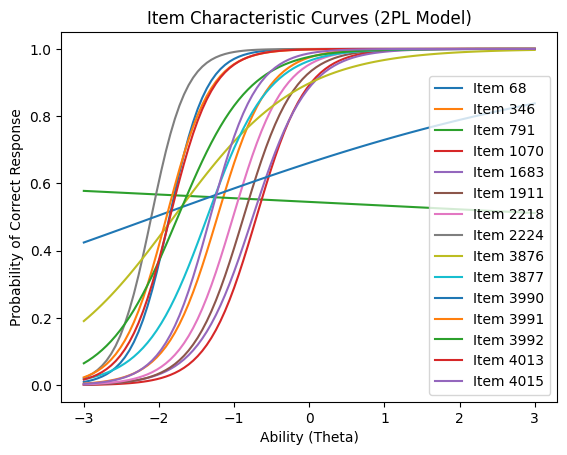

In [8]:
df = final_matrix_cleaned.copy()

# Create the feature matrix (X) with both raw_ability_est and raw_difficulty
X = df[['raw_ability_est', 'raw_difficulty']]  # Ability and difficulty as  features

# Initialize lists to store the coefficients (discrimination) and intercepts (difficulty)
coefficients = []
intercepts = []

# Loop through each item (column in your matrix)
for item in df.columns:
    if item not in ['raw_ability_est', 'raw_difficulty']:  # Skip the ability and difficulty columns
        y = df[item]  # The item responses(binary: 0 or 1)

        # Fit the logistic regression model using both ability and difficulty
        model = LogisticRegression(solver='liblinear')
        model.fit(X, y)

        # Store coefficients (discrimination) and intercepts(difficulty)
        coefficients.append(model.coef_[0])  # Coefficients for both features
        intercepts.append(model.intercept_[0])  # Difficulty (intercept)

# Print out the parameters for each item
for i, item in enumerate(df.columns):
    if item not in ['raw_ability_est', 'raw_difficulty']:  # Skip the ability and difficulty columns
        print(f"Item {item}: Coefficients (Discrimination, Difficulty) = {coefficients[i]}, Intercept = {intercepts[i]}")

# Plot Item Characteristic Curves (ICCs)
theta_values = np.linspace(-3, 3, 100)  # Range of ability values (theta)
for i, item in enumerate(df.columns):
    if item not in ['raw_ability_est', 'raw_difficulty']:  # Skip the ability and difficulty columns
        a = coefficients[i][0]  # Discrimination parameter for item i (from the first feature)
        d = coefficients[i][1]  # Difficulty parameter for item i (from the second feature)
        b = intercepts[i]  # Intercept (difficulty parameter)

        # Calculate probability of correct response for each ability (theta)
        P = 1 / (1 + np.exp(-(a * (theta_values - b) + d)))  # Logistic function (2PL)

        # Plot the ICC for this item
        plt.plot(theta_values, P, label=f"Item {item}")

plt.xlabel('Ability (Theta)')
plt.ylabel('Probability of Correct Response')
plt.title('Item Characteristic Curves (2PL Model)')
plt.legend()
plt.show()

# RELIABITY & VALIDITY

###Calcualting Cronbach's alpha for reliability testing

In [10]:
# Extract only the item response columns (skip the ability and difficulty columns)
response_data = df.drop(columns=['raw_ability_est', 'raw_difficulty'])

# Cronbach's alpha formula
def cronbach_alpha(data):
    # Number of items (columns)
    N = data.shape[1]

    # Variance of each item (column)
    item_variances = data.var(ddof=1)

    # Total variance (variance of the sum of items)
    total_variance = data.sum(axis=1).var(ddof=1)

    # Cronbach's alpha formula
    alpha = (N / (N - 1)) * (1 - item_variances.sum() / total_variance)
    return alpha

# Calculate Cronbach's alpha for the response data
alpha = cronbach_alpha(response_data)
print(f"Cronbach's Alpha: {alpha}")


Cronbach's Alpha: 0.5388903399293834


### Calculating log-likelihood (Negative Log-Loss): Measures the accuracy of the model's predicted probabilities for correct responses. The closer this value is to 0, the better the model predicts the response probabilities

In [13]:
log_likelihoods = []

for item in df.columns:
    if item not in ['raw_ability_est', 'raw_difficulty']:  # Skip the ability and difficulty columns
        y = df[item]  # The item responses (binary: 0 or 1)

        # Include both raw_ability_est and raw_difficulty as features
        X_item = df[['raw_ability_est', 'raw_difficulty']]

        model = LogisticRegression(solver='liblinear')
        model.fit(X_item, y)

        # Predict probabilities
        y_pred_prob = model.predict_proba(X_item)[:, 1]

        # Compute log-likelihood (negative log loss)
        log_likelihood = -log_loss(y, y_pred_prob, normalize=False)
        log_likelihoods.append(log_likelihood)
        print(f"Item {item}: Log-Likelihood = {log_likelihood:.4f}")

# Total Log-Likelihood for the model
total_log_likelihood = sum(log_likelihoods)
print(f"Total Log-Likelihood: {total_log_likelihood:.4f}")


Item 68: Log-Likelihood = -203.0071
Item 346: Log-Likelihood = -222.4174
Item 791: Log-Likelihood = -171.1750
Item 1070: Log-Likelihood = -179.6264
Item 1683: Log-Likelihood = -200.2319
Item 1911: Log-Likelihood = -201.4758
Item 2218: Log-Likelihood = -212.2005
Item 2224: Log-Likelihood = -186.2811
Item 3876: Log-Likelihood = -156.2016
Item 3877: Log-Likelihood = -223.6453
Item 3990: Log-Likelihood = -164.9851
Item 3991: Log-Likelihood = -192.8920
Item 3992: Log-Likelihood = -180.6957
Item 4013: Log-Likelihood = -199.8972
Item 4015: Log-Likelihood = -218.7664
Total Log-Likelihood: -2913.4984


###Evaluating the effectiveness of the adaptive algorithm

In [15]:
mse_values = []

for item in df.columns:
    if item not in ['raw_ability_est', 'raw_difficulty']:  # Skip the ability and difficulty columns
        y = df[item]  # The item responses (binary: 0 or 1)

        # Include both raw_ability_est and raw_difficulty as features
        X_item = df[['raw_ability_est', 'raw_difficulty']]

        model = LogisticRegression(solver='liblinear')
        model.fit(X_item, y)

        # Predict probabilities
        y_pred_prob = model.predict_proba(X_item)[:, 1]

        # Calculate MSE (Mean Squared Error)
        mse = mean_squared_error(y, y_pred_prob)
        mse_values.append(mse)
        print(f"Item {item}: MSE = {mse:.4f}")

# Total MSE for the model (average of all items)
total_mse = sum(mse_values) / len(mse_values)
print(f"Total MSE: {total_mse:.4f}")


Item 68: MSE = 0.1970
Item 346: MSE = 0.2224
Item 791: MSE = 0.1551
Item 1070: MSE = 0.1685
Item 1683: MSE = 0.1930
Item 1911: MSE = 0.1949
Item 2218: MSE = 0.2090
Item 2224: MSE = 0.1773
Item 3876: MSE = 0.1383
Item 3877: MSE = 0.2238
Item 3990: MSE = 0.1477
Item 3991: MSE = 0.1850
Item 3992: MSE = 0.1690
Item 4013: MSE = 0.1924
Item 4015: MSE = 0.2171
Total MSE: 0.1860


# Using MultiLayer Perceptron to improve the adaptive system.

In [20]:
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score

# List to store the accuracy values for each item
accuracy_values = []

# Loop through each item (excluding 'raw_ability_est' and 'raw_difficulty')
for item in df.columns:
    if item not in ['raw_ability_est', 'raw_difficulty']:  # Skip both ability and difficulty columns
        y = df[item]  # Item responses (binary: 0 or 1)
        X_item = df[['raw_ability_est']]  # Use raw ability estimates as the feature for prediction

        # Initialize a Multilayer Perceptron model with one hidden layer and 10 neurons
        model = MLPClassifier(hidden_layer_sizes=(15,), max_iter=1000, random_state=42)

        # Fit the model
        model.fit(X_item, y)

        # Predict the responses using the fitted model
        y_pred = model.predict(X_item)

        # Calculate the accuracy of the model for this item
        accuracy = accuracy_score(y, y_pred)
        accuracy_values.append(accuracy)
        print(f"Item {item}: Accuracy = {accuracy:.4f}")

# Calculate the overall accuracy of the system
total_accuracy = sum(accuracy_values) / len(accuracy_values)
print(f"Total Accuracy: {total_accuracy:.4f}")


Item 68: Accuracy = 0.7086
Item 346: Accuracy = 0.6400
Item 791: Accuracy = 0.8086
Item 1070: Accuracy = 0.7514
Item 1683: Accuracy = 0.6943
Item 1911: Accuracy = 0.7029
Item 2218: Accuracy = 0.6714
Item 2224: Accuracy = 0.7457
Item 3876: Accuracy = 0.8314
Item 3877: Accuracy = 0.6600
Item 3990: Accuracy = 0.8200
Item 3991: Accuracy = 0.7543
Item 3992: Accuracy = 0.7686
Item 4013: Accuracy = 0.7457
Item 4015: Accuracy = 0.6857
Total Accuracy: 0.7326
